In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import json
import csv
from pandas import DataFrame
import time
import gc

from IPython.display import Image
from IPython.core.display import HTML

from scipy.sparse import csr_matrix
from sklearn import preprocessing

%matplotlib inline

In [2]:
# Load data function
import glob
import pickle

FEATURES_LOCATION = './data/features/'
F_CORE = 'cnn_features_'

def get_label_from_path(file):
    return file.split('\\')[1].split('.')[0]

def load_data(mode):
    if(mode == 'test'):
        pickle_path = F_CORE + mode
        data = pickle.load(open(FEATURES_LOCATION + pickle_path + '.pkl', 'rb'))
        to_return = {}
        for key, value in list(data.items()):
            to_return[get_label_from_path(key)] = value.reshape(1,-1)
        return to_return, None
    
    pickle_path = F_CORE + mode + '_'
    
    data = {}
    for i in range(1,129):
        data[i] = pickle.load(open(FEATURES_LOCATION + pickle_path + str(i) + '.pkl', 'rb'))
        
    X = []
    y = []
    for key, value in list(data.items()):
        the_class = key
        features = np.array(list(value.values()))
        for feature in features:
            y.append(the_class)
            X.append(feature)

    return np.array(X), np.array(y)

In [3]:
# Load data
X, y = load_data('train')
X_val, y_val = load_data('valid')

# Extract number of labels in the training data
num_labels = np.unique(y).shape[0]
num_features = X.shape[1]
num_trainobs = X.shape[0]

# Create one hot encoding for training and validation features
lb = preprocessing.LabelBinarizer()
lb.fit(y)
y = lb.transform(y)
y_val = lb.transform(y_val)

X_test, _ = load_data('test')
len(X_test.items())

X_test_arr = np.array(list(X_test.values()))
X_test_arr = X_test_arr.reshape(-1,2048)

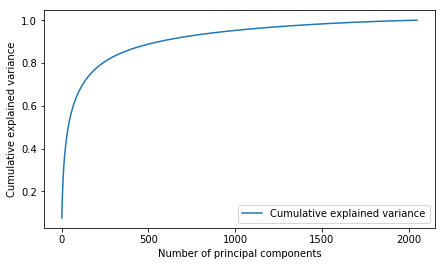

In [4]:
# Perform PCA preprocessing

# Compute eigenvalues and eigenvectors
X_cov = np.cov(X.T, bias = True) # compute covariance matrix
eigvals, eigvecs = np.linalg.eigh(X_cov) # compute eigenvalues and eigenvectors
eigvals = np.flip(eigvals, axis = 0) # flip the order of eigenvalues
eigvecs = np.flip(eigvecs, axis = 1) # flip the order of eigenvectors
explained = np.cumsum(eigvals/np.sum(eigvals)) # compute cumulative explained variance

# Plot eigenspectrum
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, eigvals.shape[0] + 1), explained, label = "Cumulative explained variance")
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.legend(loc = 4)

# Compute principal component values
k = 1000 # Number of principal components
N = X.shape[0] # Extract number of training samples
Z = np.empty([N, k]) # Preallocate space
Z[:] = np.nan # Set all elements equal to nan
x_bar = np.mean(X, axis = 0) # compute mean for demeaning
X_demean = X - x_bar # Demean features
U_k = eigvecs[:, 0:k] # Extract the k first eigenvectors

N_val = X_val.shape[0] # Extract number of validation samples
Z_val = np.empty([N_val, k]) # Preallocate space for validation eigenvector mapping
Z_val[:] = np.nan # Set all elements equal to nan
X_val_demean = X_val - x_bar # Demean validation features

N_test = X_test_arr.shape[0] # Extract number of test samples
Z_test = np.empty([N_test, k]) # Preallocate space for test eigenvector mapping
Z_test[:] = np.nan # Set all elements equal to nan
X_test_demean = X_test_arr - x_bar # Demean test features

# Compute principal components for training set
for n in np.arange(0, N):
    Z[n, :] = np.matmul(U_k.T, X_demean[n, :])
    
# Compute principal components for validation set
for nv in np.arange(0, N_val):
    Z_val[nv, :] = np.matmul(U_k.T, X_val_demean[nv, :])
    
# Compute principal components for test set
for nt in np.arange(0, N_test):
    Z_test[nt, :] = np.matmul(U_k.T, X_test_demean[nt, :])

# Give the principal components the correct names
X = Z
X_val = Z_val
X_test_arr = Z_test
num_features = k

# Convert to float32
X = np.float32(X)
X_val = np.float32(X_val)
X_test_arr = np.float32(X_test_arr)

In [48]:
# Tensorflow graph set up
graph = tf.Graph()
with graph.as_default():
    
    # Variables
    batch_size = 6000 # mini batch for SGD
    lamb = 0.00035 # regularization
    learn_rate = 0.75 # learning rate
    
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, num_features))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(X_val)
    tf_test_dataset = tf.constant(X_test_arr)
    
    # Initial weights and biases for output/logit layer
    w_logit = tf.Variable(tf.random_normal([num_features, num_labels]))
    b_logit = tf.Variable(tf.random_normal([num_labels]))
    
    def model(data):
        return tf.matmul(data, w_logit) + b_logit
    
    # Training computations
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    regularized_loss = tf.nn.l2_loss(w_logit)
    total_loss = loss + lamb * regularized_loss
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(learn_rate).minimize(total_loss)
    
    # Predictions for training, validation and test data
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [49]:
def accuracy(predictions, labels):
    return(100 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [50]:
num_steps = 20001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        
        # Generate minibatch
        ind = np.random.choice(num_trainobs, size = batch_size, replace = False)
        batch_data = X[ind, :]
        batch_labels = y[ind, :]
        
        # Prepare a dictionary telling the session where to feed the minibatch
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 1000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), y_val))
    
    predictionstf = test_prediction.eval()

Initialized
Minibatch loss at step 0: 82.940887
Minibatch accuracy: 0.6%
Validation accuracy: 0.7%
Minibatch loss at step 1000: 5.109143
Minibatch accuracy: 64.9%
Validation accuracy: 58.7%
Minibatch loss at step 2000: 2.567595
Minibatch accuracy: 70.9%
Validation accuracy: 63.1%
Minibatch loss at step 3000: 1.417603
Minibatch accuracy: 76.0%
Validation accuracy: 66.1%
Minibatch loss at step 4000: 0.915502
Minibatch accuracy: 78.7%
Validation accuracy: 68.1%
Minibatch loss at step 5000: 0.657867
Minibatch accuracy: 82.1%
Validation accuracy: 70.3%
Minibatch loss at step 6000: 0.524166
Minibatch accuracy: 84.5%
Validation accuracy: 72.6%
Minibatch loss at step 7000: 0.500917
Minibatch accuracy: 85.9%
Validation accuracy: 73.9%
Minibatch loss at step 8000: 0.468382
Minibatch accuracy: 86.3%
Validation accuracy: 74.9%
Minibatch loss at step 9000: 0.453411
Minibatch accuracy: 87.4%
Validation accuracy: 75.6%
Minibatch loss at step 10000: 0.467596
Minibatch accuracy: 87.2%
Validation accura

In [51]:
# Convert predictions from one-hot to actual labels and print csv
y_pred = lb.inverse_transform(predictionstf)

predictions = {}
for i, index in enumerate(X_test.keys()):
    predictions[int(index)] = y_pred[i]
    
from collections import Counter
counted = Counter(predictions.values())
most_common_class = counted.most_common()[0][0]

for index in range(1, 12801):
    if(index not in predictions.keys()):
        predictions[index] = most_common_class
        
ids = []
values = []
for key, value in predictions.items():
    ids.append(key)
    values.append(value)
    
out_dict = {}
out_dict['id'] = ids
out_dict['predicted'] = values

keys = sorted(out_dict.keys())
COL_WIDTH = 6
FMT = "%%-%ds" % COL_WIDTH

with open('predictions_PCA2.csv', 'w') as csv:
    # Write keys    
    csv.write(','.join([k for k in keys]) + '\n')

    # Assume all values of dict are equal
    for i in range(len(out_dict[keys[0]])):
        csv.write(','.join([FMT % out_dict[k][i] for k in keys]) + '\n')